**🔴 الخلية 0 — تثبيت المكتبات (أول خلية في Kaggle)**

In [ ]:
!pip install -q pesq pystoi librosa soundfile jiwer transformers onnxruntime



  Preparing metadata (setup.py) ... done
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 17.4/17.4 MB 104.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 3.2/3.2 MB 103.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 46.0/46.0 kB 4.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 86.8/86.8 kB 8.9 MB/s eta 0:00:00


🟢 الخلية 1 — Imports + Paths

In [5]:
import os
import random
import numpy as np
import torch
import torch.nn as nn
import torch.nn.functional as F
import torchaudio

from torch.utils.data import Dataset, DataLoader
from tqdm import tqdm


In [ ]:
DATA_ROOT = "/kaggle/input/voicebank-demand-16k"
WORK_DIR = "/kaggle/working"

CKPT_DIR = f"{WORK_DIR}/checkpoints"
os.makedirs(CKPT_DIR, exist_ok=True)


**🟢 الخلية 2 — Configuration**

In [6]:
CONFIG = {
    "SR": 16000,
    "SEG_SEC": 2.0,
    "N_FFT": 512,
    "HOP": 128,
    "WIN": 512,
    "BATCH": 16,
    "EPOCHS": 50
}

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print("Device:", device)

STFT_WINDOW = torch.hann_window(CONFIG["WIN"]).to(device)


Device: cuda


**🟢 الخلية 3 — Speaker Split (بدون Shuffle ❗)**

In [ ]:
clean_train_dir = f"{DATA_ROOT}/clean_trainset_28spk_wav"
files = sorted(os.listdir(clean_train_dir))
all_speakers = sorted({f.split("_")[0] for f in files})

num_val = max(1, int(0.15 * len(all_speakers)))
val_speakers = all_speakers[:num_val]
train_speakers = all_speakers[num_val:]

print("Train speakers:", train_speakers)
print("Val speakers:", val_speakers)


Train speakers: ['p231', 'p233', 'p236', 'p239', 'p243', 'p244', 'p250', 'p254', 'p256', 'p258', 'p259', 'p267', 'p268', 'p269', 'p270', 'p273', 'p274', 'p276', 'p277', 'p278', 'p279', 'p282', 'p286', 'p287']
Val speakers: ['p226', 'p227', 'p228', 'p230']


**🟢 الخلية 4 — Dataset (Local Files)**

In [ ]:
class VoiceBankLocal(Dataset):
    def __init__(self, clean_dir, noisy_dir, speakers):
        self.clean_dir = clean_dir
        self.noisy_dir = noisy_dir
        self.files = [
            f for f in sorted(os.listdir(clean_dir))
            if f.split("_")[0] in speakers
        ]
        self.seg_len = int(CONFIG["SR"] * CONFIG["SEG_SEC"])

    def __len__(self):
        return len(self.files)

    def _cut_pad(self, x, y):
        if x.numel() < self.seg_len:
            pad = self.seg_len - x.numel()
            return F.pad(x, (0, pad)), F.pad(y, (0, pad))
        if x.numel() > self.seg_len:
            s = random.randint(0, x.numel() - self.seg_len)
            return x[s:s+self.seg_len], y[s:s+self.seg_len]
        return x, y

    def __getitem__(self, idx):
        fname = self.files[idx]
        clean, _ = torchaudio.load(os.path.join(self.clean_dir, fname))
        noisy, _ = torchaudio.load(os.path.join(self.noisy_dir, fname))

        clean = clean.squeeze(0)
        noisy = noisy.squeeze(0)

        L = min(clean.numel(), noisy.numel())
        clean, noisy = clean[:L], noisy[:L]

        noisy, clean = self._cut_pad(noisy, clean)
        return noisy, clean


🟢 الخلية 5 — DataLoaders

In [ ]:
train_ds = VoiceBankLocal(
    f"{DATA_ROOT}/clean_trainset_28spk_wav",
    f"{DATA_ROOT}/noisy_trainset_28spk_wav",
    train_speakers
)

val_ds = VoiceBankLocal(
    f"{DATA_ROOT}/clean_trainset_28spk_wav",
    f"{DATA_ROOT}/noisy_trainset_28spk_wav",
    val_speakers
)

train_loader = DataLoader(train_ds, batch_size=CONFIG["BATCH"], shuffle=True)
val_loader = DataLoader(val_ds, batch_size=1, shuffle=False)


🟢 الخلية 6 — Model

In [7]:
def match_size(x, ref):
    _, _, H, W = x.shape
    _, _, Hr, Wr = ref.shape

    if H > Hr:
        x = x[:, :, :Hr, :]
    if W > Wr:
        x = x[:, :, :, :Wr]

    if x.shape[2] < Hr or x.shape[3] < Wr:
        pad_h = Hr - x.shape[2]
        pad_w = Wr - x.shape[3]
        x = F.pad(x, (0, pad_w, 0, pad_h))

    return x


In [2]:
class ResBlock(nn.Module):
    def __init__(self, in_ch, out_ch):
        super().__init__()
        self.c1 = nn.Conv2d(in_ch, out_ch, 3, padding=1, bias=False)
        self.n1 = nn.InstanceNorm2d(out_ch, affine=True)
        self.c2 = nn.Conv2d(out_ch, out_ch, 3, padding=1, bias=False)
        self.n2 = nn.InstanceNorm2d(out_ch, affine=True)
        self.act = nn.LeakyReLU(0.2)
        self.skip = nn.Conv2d(in_ch, out_ch, 1, bias=False) if in_ch != out_ch else None

    def forward(self, x):
        i = x if self.skip is None else self.skip(x)
        x = self.act(self.n1(self.c1(x)))
        x = self.n2(self.c2(x))
        return self.act(x + i)

class Down(nn.Module):
    def __init__(self, in_ch, out_ch):
        super().__init__()
        self.net = nn.Sequential(
            nn.Conv2d(in_ch, out_ch, 3, stride=2, padding=1, bias=False),
            nn.InstanceNorm2d(out_ch, affine=True),
            nn.LeakyReLU(0.2),
            ResBlock(out_ch, out_ch)
        )

    def forward(self, x):
        return self.net(x)

class Up(nn.Module):
    def __init__(self, in_ch, skip_ch, out_ch):
        super().__init__()
        self.up = nn.ConvTranspose2d(in_ch, out_ch, 4, 2, 1, bias=False)
        self.norm = nn.InstanceNorm2d(out_ch, affine=True)
        self.act = nn.LeakyReLU(0.2)
        self.res = ResBlock(out_ch + skip_ch, out_ch)

    def forward(self, x, skip):
        x = self.act(self.norm(self.up(x)))
        x = match_size(x, skip)
        x = torch.cat([x, skip], dim=1)
        return self.res(x)

class DualStreamResUNet(nn.Module):
    def __init__(self, base=32):
        super().__init__()
        self.enc1 = ResBlock(1, base)
        self.enc2 = Down(base, base*2)
        self.enc3 = Down(base*2, base*4)
        self.enc4 = Down(base*4, base*8)

        self.bot = ResBlock(base*8, base*8)

        self.up3s = Up(base*8, base*4, base*4)
        self.up2s = Up(base*4, base*2, base*2)
        self.up1s = Up(base*2, base, base)

        self.up3n = Up(base*8, base*4, base*4)
        self.up2n = Up(base*4, base*2, base*2)
        self.up1n = Up(base*2, base, base)

        self.speech_head = nn.Sequential(nn.Conv2d(base, 1, 1), nn.Sigmoid())
        self.noise_head = nn.Sequential(nn.Conv2d(base, 1, 1), nn.Sigmoid())

    def forward(self, x):
        e1 = self.enc1(x)
        e2 = self.enc2(e1)
        e3 = self.enc3(e2)
        e4 = self.enc4(e3)

        b = self.bot(e4)

        xs = self.up3s(b, e3)
        xs = self.up2s(xs, e2)
        xs = self.up1s(xs, e1)

        xn = self.up3n(b, e3)
        xn = self.up2n(xn, e2)
        xn = self.up1n(xn, e1)

        return self.speech_head(xs), self.noise_head(xn)


In [3]:
model = DualStreamResUNet()

if torch.cuda.device_count() > 1:
    print("Using", torch.cuda.device_count(), "GPUs")
    model = nn.DataParallel(model)

model = model.to(device)

optimizer = torch.optim.AdamW(model.parameters(), lr=1e-4)


**🟢 CELL 7 — STFT / ISTFT**

In [ ]:
STFT_WINDOW = None  # cache

def gpu_stft(w):
    global STFT_WINDOW

    device = w.device
    win_length = CONFIG["WIN"]

    if STFT_WINDOW is None or STFT_WINDOW.device != device:
        STFT_WINDOW = torch.hann_window(
            win_length,
            device=device
        )

    s = torch.stft(
        w,
        n_fft=CONFIG["N_FFT"],
        hop_length=CONFIG["HOP"],
        win_length=win_length,
        window=STFT_WINDOW,
        return_complex=True
    )

    mag = torch.log1p(torch.abs(s))
    phase = torch.angle(s)
    return mag, phase


def gpu_istft(m, p, length):
    global STFT_WINDOW

    device = m.device
    win_length = CONFIG["WIN"]

    if STFT_WINDOW is None or STFT_WINDOW.device != device:
        STFT_WINDOW = torch.hann_window(
            win_length,
            device=device
        )

    mag = torch.expm1(m).clamp_min(0.0)
    s = torch.polar(mag, p)

    w = torch.istft(
        s,
        n_fft=CONFIG["N_FFT"],
        hop_length=CONFIG["HOP"],
        win_length=win_length,
        window=STFT_WINDOW,
        length=length
    )

    return w


**🟢 CELL 8 — Losses (MR-STFT + SI-SDR)**

In [ ]:
class MRSTFTLoss(nn.Module):
    def forward(self, x, y):
        loss = 0
        for n in [512, 1024, 2048]:
            X = torch.stft(x, n, n//4, n, return_complex=True)
            Y = torch.stft(y, n, n//4, n, return_complex=True)
            loss += F.l1_loss(torch.abs(X), torch.abs(Y))
        return loss / 3

def si_sdr_loss(est, ref, eps=1e-8):
    est = est - est.mean(-1, keepdim=True)
    ref = ref - ref.mean(-1, keepdim=True)

    s = (est * ref).sum(-1, keepdim=True) / (ref**2).sum(-1, keepdim=True)
    e = est - s * ref

    return -10 * torch.log10(
        (s**2 * (ref**2).sum(-1)) / ((e**2).sum(-1) + eps)
    ).mean()


**🟢 CELL 9 — Training + Validation + Best Model**

In [ ]:
# ==========================================
# 1. Tracking for plotting
# ==========================================
history_loss = []
history_sdr = []

# ==========================================
# 2. Model setup
# ==========================================
model = DualStreamResUNet()

if torch.cuda.device_count() > 1:
    print(f"🔥 Using {torch.cuda.device_count()} GPUs!")
    model = nn.DataParallel(model)

model = model.to(device)

base_lr = 1e-4
warmup_epochs = 5
warmup_start_lr = 1e-5

optimizer = torch.optim.AdamW(
    model.parameters(),
    lr=base_lr,
    weight_decay=1e-4
)

scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(
    optimizer,
    mode="max",
    factor=0.5,
    patience=3,
    min_lr=1e-6,
)

mr_loss = MRSTFTLoss().to(device)

best_sdr = -1e9

print("🚀 Starting Training...")

# ==========================================
# 3. Training loop (Speech + Noise)
# ==========================================
for epoch in range(1, CONFIG["EPOCHS"] + 1):

    # ---------------------------
    # Warmup Learning Rate
    # ---------------------------
    if epoch <= warmup_epochs:
        lr = warmup_start_lr + (base_lr - warmup_start_lr) * (epoch / warmup_epochs)
        for param_group in optimizer.param_groups:
            param_group["lr"] = lr

    current_lr = optimizer.param_groups[0]["lr"]

    # ---------------------------
    # Training
    # ---------------------------
    model.train()
    total_train_loss = 0.0
    num_batches = 0

    loop = tqdm(train_loader, desc=f"Epoch {epoch}")

    for noisy, clean_speech in loop:
        noisy = noisy.to(device)
        clean_speech = clean_speech.to(device)

        # اشتقاق الضجيج الحقيقي
        clean_noise = noisy - clean_speech

        optimizer.zero_grad(set_to_none=True)

        # STFT
        mag, phase = gpu_stft(noisy)

        # Masks
        Ms, Mn = model(mag.unsqueeze(1))

        # Speech reconstruction
        speech_pred = gpu_istft(
            torch.log1p(torch.expm1(mag) * Ms.squeeze(1)),
            phase,
            noisy.shape[-1]
        )

        # Noise reconstruction
        noise_pred = gpu_istft(
            torch.log1p(torch.expm1(mag) * Mn.squeeze(1)),
            phase,
            noisy.shape[-1]
        )

        # ---------- Loss ----------
        loss_speech = mr_loss(speech_pred, clean_speech)
        loss_noise = mr_loss(noise_pred, clean_noise)

        loss = loss_speech + 0.5 * loss_noise

        # Mask consistency
        mask_consistency = torch.mean((Ms + Mn - 1.0) ** 2)
        loss += 0.01 * mask_consistency

        # SI-SDR curriculum
        if epoch > 1:
            sdr_w = min(0.3, epoch / 20 * 0.3)
            loss += sdr_w * si_sdr_loss(speech_pred, clean_speech)
            loss += 0.1 * sdr_w * si_sdr_loss(noise_pred, clean_noise)

        # ---------- Backprop ----------
        loss.backward()
        torch.nn.utils.clip_grad_norm_(model.parameters(), 5.0)
        optimizer.step()

        total_train_loss += loss.item()
        num_batches += 1
        loop.set_postfix(
            loss=f"{loss.item():.4f}",
            lr=f"{current_lr:.2e}"
        )

    avg_train_loss = total_train_loss / num_batches
    history_loss.append(avg_train_loss)

    # ---------------------------
    # Validation (Speech only)
    # ---------------------------
    model.eval()
    sdr = 0.0

    with torch.no_grad():
        for noisy, clean_speech in val_loader:
            noisy = noisy.to(device)
            clean_speech = clean_speech.to(device)

            mag, phase = gpu_stft(noisy)
            Ms, _ = model(mag.unsqueeze(1))

            speech_pred = gpu_istft(
                torch.log1p(torch.expm1(mag) * Ms.squeeze(1)),
                phase,
                noisy.shape[-1]
            )

            sdr += -si_sdr_loss(speech_pred, clean_speech).mean().item()

    avg_sdr = sdr / len(val_loader)
    history_sdr.append(avg_sdr)

    # Scheduler step (بعد warmup)
    if epoch > warmup_epochs:
        scheduler.step(avg_sdr)

    print(
        f"📊 Epoch {epoch} | "
        f"LR: {current_lr:.2e} | "
        f"Avg Loss: {avg_train_loss:.4f} | "
        f"Val SI-SDR: {avg_sdr:.2f} dB"
    )

    # ---------------------------
    # Save best model
    # ---------------------------
    if avg_sdr > best_sdr:
        best_sdr = avg_sdr

        state_dict = (
            model.module.state_dict()
            if isinstance(model, nn.DataParallel)
            else model.state_dict()
        )

        torch.save(state_dict, f"{CKPT_DIR}/best_model.pth")
        print("✅ Best model saved")

print("🏁 Training Finished")


🔥 Using 2 GPUs!
🚀 Starting Training...


Epoch 1:   0%|          | 0/630 [00:00<?, ?it/s]/usr/local/lib/python3.12/dist-packages/torchaudio/_backend/utils.py:213: UserWarning: In 2.9, this function's implementation will be changed to use torchaudio.load_with_torchcodec` under the hood. Some parameters like ``normalize``, ``format``, ``buffer_size``, and ``backend`` will be ignored. We recommend that you port your code to rely directly on TorchCodec's decoder instead: https://docs.pytorch.org/torchcodec/stable/generated/torchcodec.decoders.AudioDecoder.html#torchcodec.decoders.AudioDecoder.
  warnings.warn(
/usr/local/lib/python3.12/dist-packages/torchaudio/_backend/ffmpeg.py:88: UserWarning: torio.io._streaming_media_decoder.StreamingMediaDecoder has been deprecated. This deprecation is part of a large refactoring effort to transition TorchAudio into a maintenance phase. The decoding and encoding capabilities of PyTorch for both audio and video are being consolidated into TorchCodec. Please see https://github.com/pytorch/audi

📊 Epoch 1 | LR: 2.80e-05 | Avg Loss: 0.2305 | Val SI-SDR: 13.20 dB
✅ Best model saved


Epoch 2: 100%|██████████| 630/630 [08:41<00:00,  1.21it/s, loss=-0.2988, lr=4.60e-05]


📊 Epoch 2 | LR: 4.60e-05 | Avg Loss: -0.2619 | Val SI-SDR: 14.00 dB
✅ Best model saved


Epoch 3: 100%|██████████| 630/630 [08:49<00:00,  1.19it/s, loss=-0.5288, lr=6.40e-05]


📊 Epoch 3 | LR: 6.40e-05 | Avg Loss: -0.5241 | Val SI-SDR: 14.38 dB
✅ Best model saved


Epoch 4: 100%|██████████| 630/630 [08:37<00:00,  1.22it/s, loss=-0.8628, lr=8.20e-05]


📊 Epoch 4 | LR: 8.20e-05 | Avg Loss: -0.7835 | Val SI-SDR: 14.56 dB
✅ Best model saved


Epoch 5: 100%|██████████| 630/630 [08:38<00:00,  1.21it/s, loss=-1.0032, lr=1.00e-04]


📊 Epoch 5 | LR: 1.00e-04 | Avg Loss: -1.0375 | Val SI-SDR: 14.85 dB
✅ Best model saved


Epoch 6: 100%|██████████| 630/630 [08:39<00:00,  1.21it/s, loss=-1.3678, lr=1.00e-04]


📊 Epoch 6 | LR: 1.00e-04 | Avg Loss: -1.3030 | Val SI-SDR: 14.69 dB


Epoch 7: 100%|██████████| 630/630 [08:36<00:00,  1.22it/s, loss=-1.7193, lr=1.00e-04]


📊 Epoch 7 | LR: 1.00e-04 | Avg Loss: -1.5689 | Val SI-SDR: 14.92 dB
✅ Best model saved


Epoch 8: 100%|██████████| 630/630 [08:40<00:00,  1.21it/s, loss=-1.4123, lr=1.00e-04]


📊 Epoch 8 | LR: 1.00e-04 | Avg Loss: -1.8289 | Val SI-SDR: 15.04 dB
✅ Best model saved


Epoch 9: 100%|██████████| 630/630 [08:38<00:00,  1.22it/s, loss=-1.8834, lr=1.00e-04]


📊 Epoch 9 | LR: 1.00e-04 | Avg Loss: -2.0898 | Val SI-SDR: 15.13 dB
✅ Best model saved


Epoch 10: 100%|██████████| 630/630 [08:40<00:00,  1.21it/s, loss=-2.2179, lr=1.00e-04]


📊 Epoch 10 | LR: 1.00e-04 | Avg Loss: -2.3579 | Val SI-SDR: 15.24 dB
✅ Best model saved


Epoch 11: 100%|██████████| 630/630 [08:34<00:00,  1.22it/s, loss=-2.5922, lr=1.00e-04]


📊 Epoch 11 | LR: 1.00e-04 | Avg Loss: -2.6233 | Val SI-SDR: 15.24 dB
✅ Best model saved


Epoch 12: 100%|██████████| 630/630 [08:40<00:00,  1.21it/s, loss=-2.9654, lr=1.00e-04]


📊 Epoch 12 | LR: 1.00e-04 | Avg Loss: -2.8889 | Val SI-SDR: 15.37 dB
✅ Best model saved


Epoch 13: 100%|██████████| 630/630 [08:36<00:00,  1.22it/s, loss=-2.8429, lr=1.00e-04]


📊 Epoch 13 | LR: 1.00e-04 | Avg Loss: -3.1579 | Val SI-SDR: 15.45 dB
✅ Best model saved


Epoch 14: 100%|██████████| 630/630 [08:42<00:00,  1.21it/s, loss=-3.4221, lr=1.00e-04]


📊 Epoch 14 | LR: 1.00e-04 | Avg Loss: -3.4165 | Val SI-SDR: 15.27 dB


Epoch 15: 100%|██████████| 630/630 [08:27<00:00,  1.24it/s, loss=-3.3674, lr=1.00e-04]


📊 Epoch 15 | LR: 1.00e-04 | Avg Loss: -3.6944 | Val SI-SDR: 15.49 dB
✅ Best model saved


Epoch 16: 100%|██████████| 630/630 [08:29<00:00,  1.24it/s, loss=-3.9588, lr=1.00e-04]


📊 Epoch 16 | LR: 1.00e-04 | Avg Loss: -3.9645 | Val SI-SDR: 15.54 dB
✅ Best model saved


Epoch 17: 100%|██████████| 630/630 [08:30<00:00,  1.23it/s, loss=-4.3981, lr=1.00e-04]


📊 Epoch 17 | LR: 1.00e-04 | Avg Loss: -4.2356 | Val SI-SDR: 15.60 dB
✅ Best model saved


Epoch 18: 100%|██████████| 630/630 [08:31<00:00,  1.23it/s, loss=-5.1660, lr=1.00e-04]


📊 Epoch 18 | LR: 1.00e-04 | Avg Loss: -4.5037 | Val SI-SDR: 15.51 dB


Epoch 19: 100%|██████████| 630/630 [08:45<00:00,  1.20it/s, loss=-4.1488, lr=1.00e-04]


📊 Epoch 19 | LR: 1.00e-04 | Avg Loss: -4.7736 | Val SI-SDR: 15.63 dB
✅ Best model saved


Epoch 20: 100%|██████████| 630/630 [08:35<00:00,  1.22it/s, loss=-5.0479, lr=1.00e-04]


📊 Epoch 20 | LR: 1.00e-04 | Avg Loss: -5.0439 | Val SI-SDR: 15.65 dB
✅ Best model saved


Epoch 21: 100%|██████████| 630/630 [08:38<00:00,  1.22it/s, loss=-4.9390, lr=1.00e-04]


📊 Epoch 21 | LR: 1.00e-04 | Avg Loss: -5.0627 | Val SI-SDR: 15.61 dB


Epoch 22: 100%|██████████| 630/630 [08:30<00:00,  1.23it/s, loss=-5.5236, lr=1.00e-04]


📊 Epoch 22 | LR: 1.00e-04 | Avg Loss: -5.0760 | Val SI-SDR: 15.55 dB


Epoch 23: 100%|██████████| 630/630 [08:30<00:00,  1.23it/s, loss=-5.2135, lr=1.00e-04]


📊 Epoch 23 | LR: 1.00e-04 | Avg Loss: -5.0809 | Val SI-SDR: 15.79 dB
✅ Best model saved


Epoch 24: 100%|██████████| 630/630 [08:30<00:00,  1.23it/s, loss=-5.4582, lr=1.00e-04]


📊 Epoch 24 | LR: 1.00e-04 | Avg Loss: -5.0859 | Val SI-SDR: 15.61 dB


Epoch 25: 100%|██████████| 630/630 [08:27<00:00,  1.24it/s, loss=-5.0251, lr=1.00e-04]


📊 Epoch 25 | LR: 1.00e-04 | Avg Loss: -5.0983 | Val SI-SDR: 15.72 dB


Epoch 26: 100%|██████████| 630/630 [08:28<00:00,  1.24it/s, loss=-5.3237, lr=1.00e-04]


📊 Epoch 26 | LR: 1.00e-04 | Avg Loss: -5.1161 | Val SI-SDR: 15.77 dB


Epoch 27: 100%|██████████| 630/630 [08:31<00:00,  1.23it/s, loss=-4.7911, lr=1.00e-04]


📊 Epoch 27 | LR: 1.00e-04 | Avg Loss: -5.1199 | Val SI-SDR: 15.68 dB


Epoch 28: 100%|██████████| 630/630 [08:32<00:00,  1.23it/s, loss=-4.3576, lr=5.00e-05]


📊 Epoch 28 | LR: 5.00e-05 | Avg Loss: -5.1561 | Val SI-SDR: 15.86 dB
✅ Best model saved


Epoch 29: 100%|██████████| 630/630 [08:33<00:00,  1.23it/s, loss=-4.6794, lr=5.00e-05]


📊 Epoch 29 | LR: 5.00e-05 | Avg Loss: -5.1659 | Val SI-SDR: 15.84 dB


Epoch 30: 100%|██████████| 630/630 [08:32<00:00,  1.23it/s, loss=-5.0671, lr=5.00e-05]


📊 Epoch 30 | LR: 5.00e-05 | Avg Loss: -5.1681 | Val SI-SDR: 15.89 dB
✅ Best model saved


Epoch 31: 100%|██████████| 630/630 [08:33<00:00,  1.23it/s, loss=-5.5203, lr=5.00e-05]


📊 Epoch 31 | LR: 5.00e-05 | Avg Loss: -5.1825 | Val SI-SDR: 15.79 dB


Epoch 32: 100%|██████████| 630/630 [08:37<00:00,  1.22it/s, loss=-4.7707, lr=5.00e-05]


📊 Epoch 32 | LR: 5.00e-05 | Avg Loss: -5.1869 | Val SI-SDR: 15.80 dB


Epoch 33: 100%|██████████| 630/630 [08:39<00:00,  1.21it/s, loss=-4.7991, lr=5.00e-05]


📊 Epoch 33 | LR: 5.00e-05 | Avg Loss: -5.1899 | Val SI-SDR: 15.87 dB


Epoch 34: 100%|██████████| 630/630 [08:38<00:00,  1.21it/s, loss=-4.5517, lr=5.00e-05]


📊 Epoch 34 | LR: 5.00e-05 | Avg Loss: -5.2038 | Val SI-SDR: 15.89 dB
✅ Best model saved


Epoch 35: 100%|██████████| 630/630 [08:35<00:00,  1.22it/s, loss=-5.2552, lr=5.00e-05]


📊 Epoch 35 | LR: 5.00e-05 | Avg Loss: -5.2032 | Val SI-SDR: 15.86 dB


Epoch 36: 100%|██████████| 630/630 [08:31<00:00,  1.23it/s, loss=-4.9261, lr=5.00e-05]


📊 Epoch 36 | LR: 5.00e-05 | Avg Loss: -5.2072 | Val SI-SDR: 15.84 dB


Epoch 37: 100%|██████████| 630/630 [08:33<00:00,  1.23it/s, loss=-5.8460, lr=5.00e-05]


📊 Epoch 37 | LR: 5.00e-05 | Avg Loss: -5.2144 | Val SI-SDR: 15.88 dB


Epoch 38: 100%|██████████| 630/630 [08:36<00:00,  1.22it/s, loss=-5.6004, lr=5.00e-05]


📊 Epoch 38 | LR: 5.00e-05 | Avg Loss: -5.2177 | Val SI-SDR: 15.82 dB


Epoch 39: 100%|██████████| 630/630 [08:29<00:00,  1.24it/s, loss=-4.9541, lr=2.50e-05]


📊 Epoch 39 | LR: 2.50e-05 | Avg Loss: -5.2333 | Val SI-SDR: 15.91 dB
✅ Best model saved


Epoch 40: 100%|██████████| 630/630 [08:28<00:00,  1.24it/s, loss=-5.1333, lr=2.50e-05]


📊 Epoch 40 | LR: 2.50e-05 | Avg Loss: -5.2409 | Val SI-SDR: 15.90 dB


Epoch 41: 100%|██████████| 630/630 [08:28<00:00,  1.24it/s, loss=-5.5417, lr=2.50e-05]


📊 Epoch 41 | LR: 2.50e-05 | Avg Loss: -5.2477 | Val SI-SDR: 15.88 dB


Epoch 42: 100%|██████████| 630/630 [08:27<00:00,  1.24it/s, loss=-4.9050, lr=2.50e-05]


📊 Epoch 42 | LR: 2.50e-05 | Avg Loss: -5.2481 | Val SI-SDR: 15.93 dB
✅ Best model saved


Epoch 43: 100%|██████████| 630/630 [08:34<00:00,  1.23it/s, loss=-5.5571, lr=2.50e-05]


📊 Epoch 43 | LR: 2.50e-05 | Avg Loss: -5.2530 | Val SI-SDR: 15.92 dB


Epoch 44: 100%|██████████| 630/630 [08:36<00:00,  1.22it/s, loss=-5.1453, lr=2.50e-05]


📊 Epoch 44 | LR: 2.50e-05 | Avg Loss: -5.2572 | Val SI-SDR: 15.93 dB
✅ Best model saved


Epoch 45: 100%|██████████| 630/630 [08:37<00:00,  1.22it/s, loss=-4.6922, lr=2.50e-05]


📊 Epoch 45 | LR: 2.50e-05 | Avg Loss: -5.2580 | Val SI-SDR: 15.87 dB


Epoch 46: 100%|██████████| 630/630 [08:32<00:00,  1.23it/s, loss=-4.8122, lr=2.50e-05]


📊 Epoch 46 | LR: 2.50e-05 | Avg Loss: -5.2610 | Val SI-SDR: 15.95 dB
✅ Best model saved


Epoch 47: 100%|██████████| 630/630 [08:39<00:00,  1.21it/s, loss=-5.4682, lr=2.50e-05]


📊 Epoch 47 | LR: 2.50e-05 | Avg Loss: -5.2690 | Val SI-SDR: 15.94 dB


Epoch 48: 100%|██████████| 630/630 [08:34<00:00,  1.22it/s, loss=-5.5627, lr=2.50e-05]


📊 Epoch 48 | LR: 2.50e-05 | Avg Loss: -5.2722 | Val SI-SDR: 15.90 dB


Epoch 49: 100%|██████████| 630/630 [08:39<00:00,  1.21it/s, loss=-6.1744, lr=2.50e-05]


📊 Epoch 49 | LR: 2.50e-05 | Avg Loss: -5.2745 | Val SI-SDR: 15.96 dB
✅ Best model saved


Epoch 50: 100%|██████████| 630/630 [08:38<00:00,  1.22it/s, loss=-4.2631, lr=2.50e-05]


📊 Epoch 50 | LR: 2.50e-05 | Avg Loss: -5.2742 | Val SI-SDR: 15.92 dB
🏁 Training Finished


**🟢 CELL 10 — PESQ / STOI (Best Model Evaluation)**

In [8]:
!pip install -U openai-whisper jiwer


In [9]:
import os
import torch
import numpy as np
import librosa
from tqdm import tqdm

import whisper
from jiwer import wer

from pystoi import stoi
from pesq import pesq

import urllib.request
import onnxruntime as ort


In [10]:
asr_model = whisper.load_model("base")  # tiny أسرع إذا حاب


In [11]:
def transcribe_whisper(audio_np, sr):
    if sr != 16000:
        audio_np = librosa.resample(audio_np, orig_sr=sr, target_sr=16000)

    result = asr_model.transcribe(
        audio_np,
        language="en",   # عدّل لو عربي
        fp16=False
    )

    return result["text"].strip().lower()


In [12]:
os.makedirs("dnsmos", exist_ok=True)

url = "https://github.com/microsoft/DNS-Challenge/raw/master/DNSMOS/DNSMOS/model_v8.onnx"
urllib.request.urlretrieve(url, "dnsmos/dnsmos.onnx")


('dnsmos/dnsmos.onnx', <http.client.HTTPMessage at 0x7f6d19439040>)

In [13]:
class DNSMOS:
    def __init__(self, model_path="dnsmos/dnsmos.onnx"):
        self.session = ort.InferenceSession(
            model_path,
            providers=["CPUExecutionProvider"]
        )

        self.sr = 16000
        self.n_fft = 400
        self.hop_length = 160
        self.n_mels = 120
        self.max_frames = 900

    def __call__(self, audio, sr):
        if sr != self.sr:
            audio = librosa.resample(audio, orig_sr=sr, target_sr=self.sr)

        audio = audio.astype(np.float32)

        mel = librosa.feature.melspectrogram(
            y=audio,
            sr=self.sr,
            n_fft=self.n_fft,
            hop_length=self.hop_length,
            n_mels=self.n_mels,
            power=2.0
        )

        log_mel = np.log10(np.maximum(mel, 1e-10)).T

        if log_mel.shape[0] < self.max_frames:
            pad = self.max_frames - log_mel.shape[0]
            log_mel = np.pad(log_mel, ((0, pad), (0, 0)))
        else:
            log_mel = log_mel[:self.max_frames]

        log_mel = np.expand_dims(log_mel, axis=0).astype(np.float32)

        outputs = self.session.run(
            None,
            {self.session.get_inputs()[0].name: log_mel}
        )

        return float(outputs[0][0])


In [14]:
@torch.no_grad()
def evaluate_pesq_stoi_dnsmos(
    model,
    loader,
    checkpoint_path=None
):
    # ---------------------------
    # Load model
    # ---------------------------
    if isinstance(model, torch.nn.DataParallel):
        model = model.module

    if checkpoint_path and os.path.exists(checkpoint_path):
        print(f"🔄 Loading best model from: {checkpoint_path}")
        state_dict = torch.load(checkpoint_path, map_location=device)
        model.load_state_dict(state_dict)
    else:
        print("⚠️ Warning: Using current model weights.")

    model = model.to(device)
    model.eval()

    # Metrics
    # قمنا بإضافة قائمة جديدة 'wer_noisy_s' لتخزين نتائج الـ WER قبل المعالجة
    pesq_s, stoi_s, dnsmos_s, wer_s, wer_noisy_s = [], [], [], [], []

    dnsmos = DNSMOS()

    # ---------------------------
    # Loop
    # ---------------------------
    for noisy, clean_speech in tqdm(loader, desc="Evaluating Metrics"):
        noisy = noisy.to(device)
        clean_speech = clean_speech.to(device)

        # Inference
        mag, phase = gpu_stft(noisy)
        Ms, _ = model(mag.unsqueeze(1))

        speech_pred = gpu_istft(
            torch.log1p(torch.expm1(mag) * Ms.squeeze(1)),
            phase,
            noisy.shape[-1]
        )

        # To numpy
        clean_np = clean_speech.squeeze().cpu().numpy()
        pred_np  = speech_pred.squeeze().cpu().numpy()
        # [جديد] تحويل الصوت المشوش (Input) إلى numpy
        noisy_np = noisy.squeeze().cpu().numpy()

        # ---------- PESQ ----------
        try:
            pesq_s.append(
                pesq(CONFIG["SR"], clean_np, pred_np, "wb")
            )
        except:
            pass

        # ---------- STOI ----------
        stoi_s.append(
            stoi(clean_np, pred_np, CONFIG["SR"], extended=False)
        )

        # ---------- DNSMOS ----------
        dnsmos_s.append(
            dnsmos(pred_np, CONFIG["SR"])
        )

        # ---------- WER ----------
        clean_text = transcribe_whisper(clean_np, CONFIG["SR"])
        pred_text  = transcribe_whisper(pred_np, CONFIG["SR"])
        # [جديد] استخراج النص من الصوت المشوش (قبل المعالجة)
        noisy_text = transcribe_whisper(noisy_np, CONFIG["SR"])

        if len(clean_text) > 0:
            # WER بعد المعالجة
            wer_s.append(
                wer(clean_text, pred_text)
            )
            # [جديد] WER قبل المعالجة (Noisy)
            wer_noisy_s.append(
                wer(clean_text, noisy_text)
            )

        # اختياري للتسريع
        if len(wer_s) >= 100:
            break

    # ---------------------------
    # Results
    # ---------------------------
    print("\n" + "=" * 40)
    print("🌟 Final Evaluation Results")
    print(f"   Mean PESQ       : {np.mean(pesq_s):.4f}")
    print(f"   Mean STOI       : {np.mean(stoi_s):.4f}")
    print(f"   Mean DNSMOS     : {np.mean(dnsmos_s):.4f}")
    print(f"   Mean WER (Enh)  : {np.mean(wer_s):.4f}")   # بعد المعالجة
    print(f"   Mean WER (Noisy): {np.mean(wer_noisy_s):.4f}") # [جديد] قبل المعالجة
    print("=" * 40)

In [ ]:
evaluate_pesq_stoi_dnsmos(
    model,
    val_loader,
    checkpoint_path=f"{CKPT_DIR}/best_model.pth"
)


🔄 Loading best model from: /kaggle/working/checkpoints/best_model.pth


Evaluating Metrics:   0%|          | 0/1495 [00:00<?, ?it/s]/usr/local/lib/python3.12/dist-packages/torchaudio/_backend/utils.py:213: UserWarning: In 2.9, this function's implementation will be changed to use torchaudio.load_with_torchcodec` under the hood. Some parameters like ``normalize``, ``format``, ``buffer_size``, and ``backend`` will be ignored. We recommend that you port your code to rely directly on TorchCodec's decoder instead: https://docs.pytorch.org/torchcodec/stable/generated/torchcodec.decoders.AudioDecoder.html#torchcodec.decoders.AudioDecoder.
  warnings.warn(
/usr/local/lib/python3.12/dist-packages/torchaudio/_backend/ffmpeg.py:88: UserWarning: torio.io._streaming_media_decoder.StreamingMediaDecoder has been deprecated. This deprecation is part of a large refactoring effort to transition TorchAudio into a maintenance phase. The decoding and encoding capabilities of PyTorch for both audio and video are being consolidated into TorchCodec. Please see https://github.com/


🌟 Final Evaluation Results
   Mean PESQ   : 2.2644
   Mean STOI   : 0.9125
   Mean DNSMOS : 2.7769
   Mean WER    : 0.1682


**رسم**

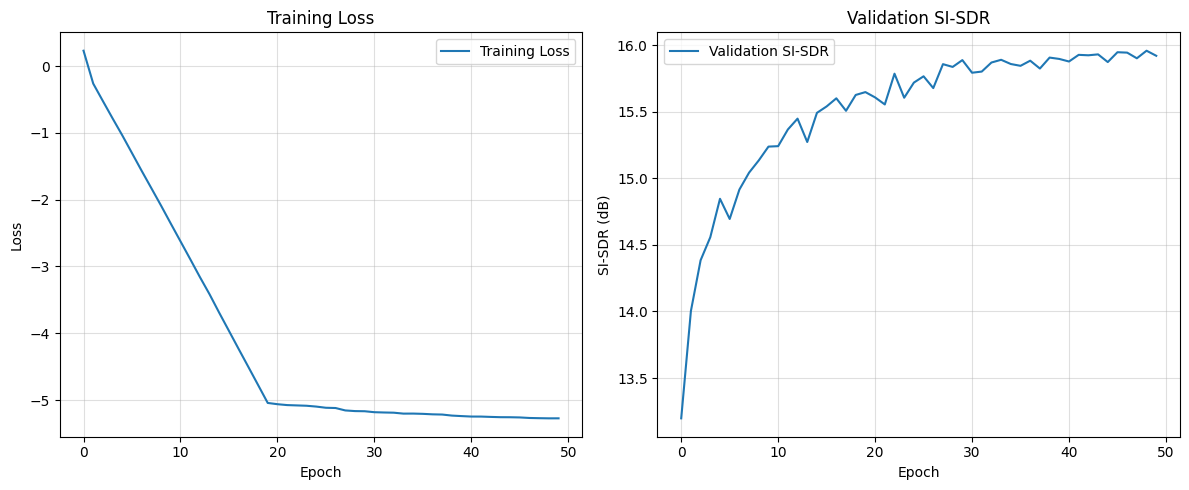

In [ ]:
import matplotlib.pyplot as plt

plt.figure(figsize=(12, 5))

# Loss
plt.subplot(1, 2, 1)
plt.plot(history_loss, label="Training Loss")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.title("Training Loss")
plt.grid(alpha=0.4)
plt.legend()

# SI-SDR
plt.subplot(1, 2, 2)
plt.plot(history_sdr, label="Validation SI-SDR")
plt.xlabel("Epoch")
plt.ylabel("SI-SDR (dB)")
plt.title("Validation SI-SDR")
plt.grid(alpha=0.4)
plt.legend()

plt.tight_layout()
plt.savefig("training_curves.png", dpi=200)
plt.show()


In [ ]:
import numpy as np

np.savez(
    "training_history.npz",
    history_loss=np.array(history_loss),
    history_sdr=np.array(history_sdr)
)

print("✅ Training history saved")


✅ Training history saved


In [17]:

!pip install -q datasets torchaudio librosa matplotlib

In [18]:
!pip install torchcodec

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.1/2.1 MB 38.0 MB/s eta 0:00:00


In [16]:
!pip install -q datasets torchaudio librosa pesq pystoi jiwer openai-whisper onnxruntime tqdm


🚀 Device: cuda
📥 تحميل VoiceBank-DEMAND Test Set...
✅ Dataset Loaded: 824
📥 جاري تجهيز نماذج التقييم...


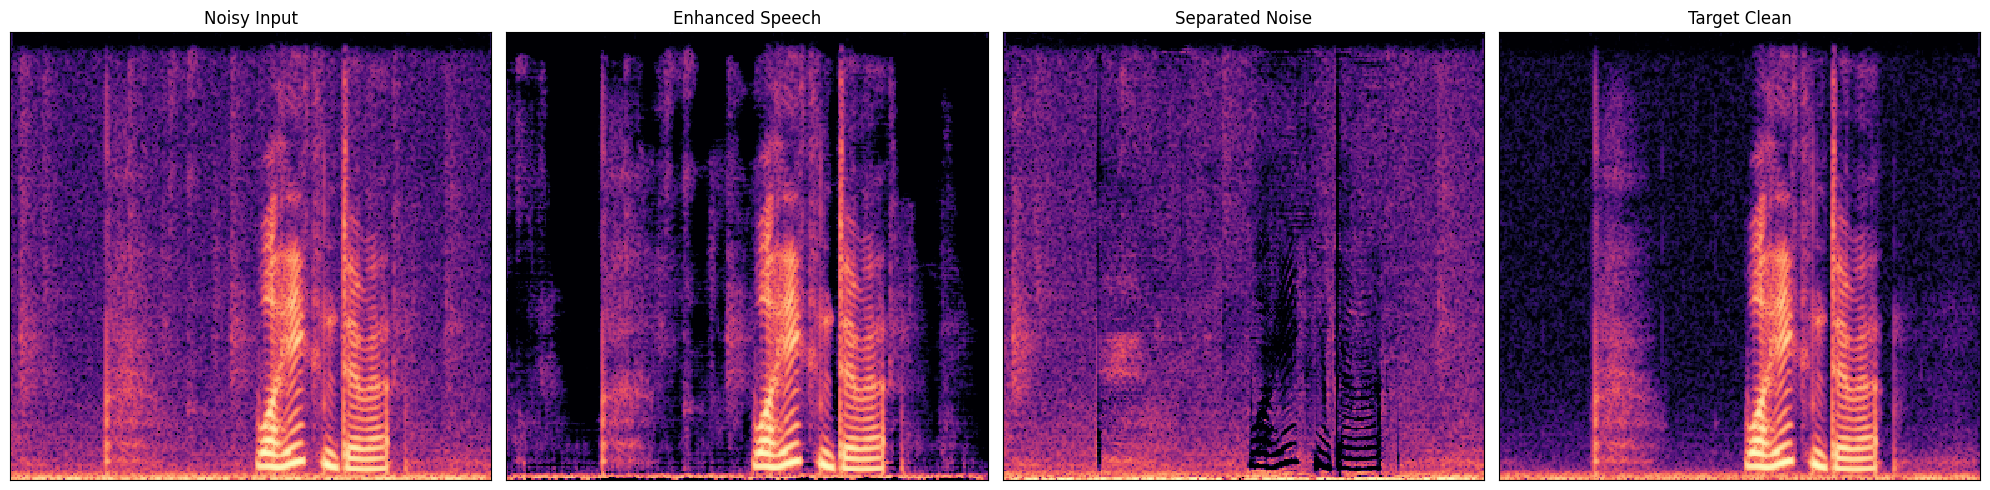

🔊 Sample 665 - Noisy:


🔊 Sample 665 - Enhanced Speech:


🔊 Sample 665 - Separated Noise:


----------------------------------------------------------------------------------------------------


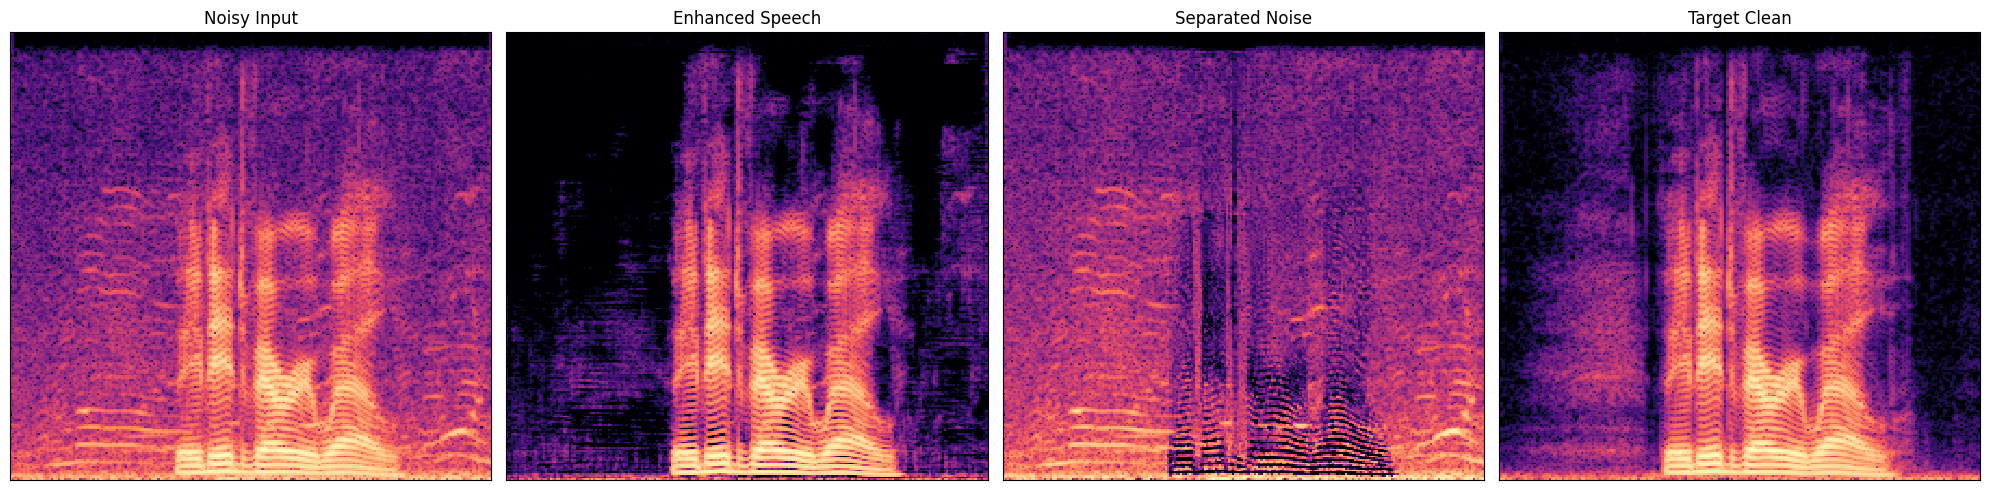

🔊 Sample 136 - Noisy:


🔊 Sample 136 - Enhanced Speech:


🔊 Sample 136 - Separated Noise:


----------------------------------------------------------------------------------------------------


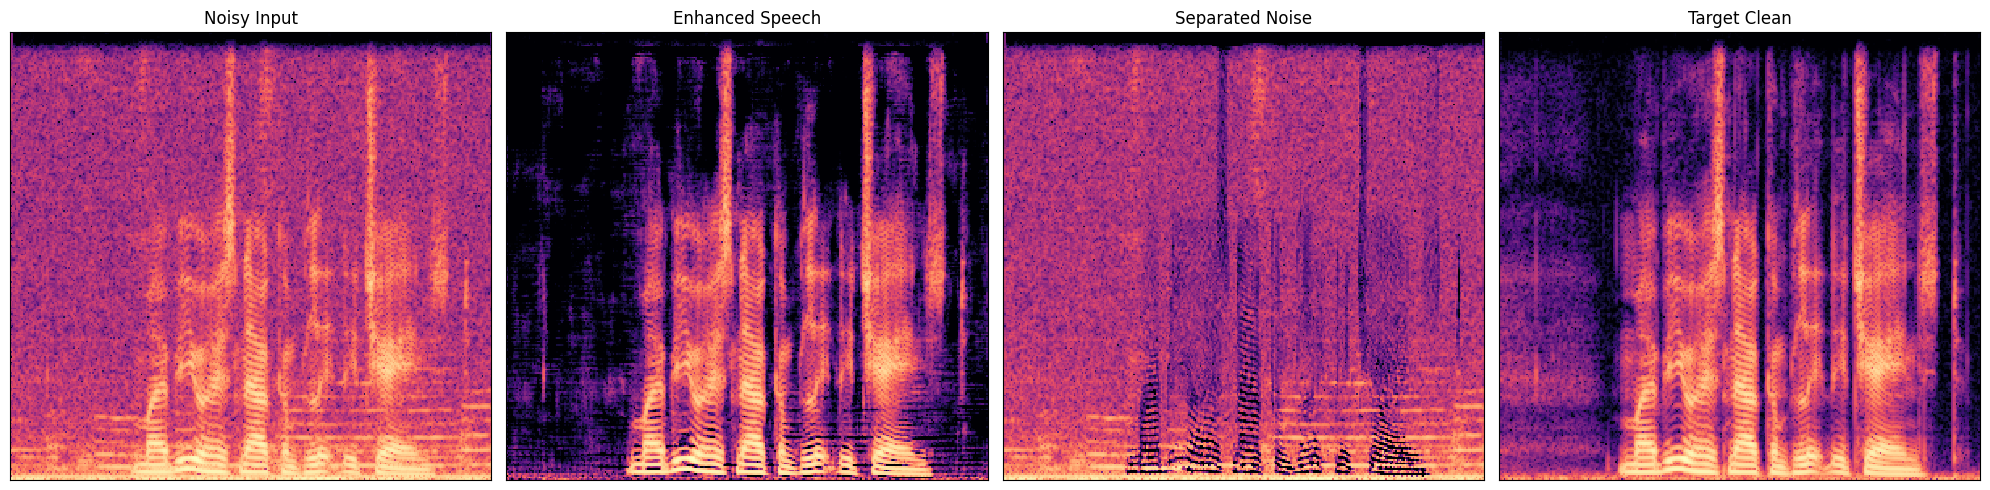

🔊 Sample 310 - Noisy:


🔊 Sample 310 - Enhanced Speech:


🔊 Sample 310 - Separated Noise:


----------------------------------------------------------------------------------------------------


📊 Evaluating Test Set:   0%|          | 0/824 [00:00<?, ?it/s]/tmp/ipython-input-1774655209.py:108: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  return float(out[0][0])
📊 Evaluating Test Set:   0%|          | 1/824 [00:10<2:28:04, 10.79s/it, PESQ=2.98]/tmp/ipython-input-1774655209.py:108: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  return float(out[0][0])
📊 Evaluating Test Set:   0%|          | 2/824 [00:11<1:08:16,  4.98s/it, PESQ=3.15]/tmp/ipython-input-1774655209.py:108: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array be


🏆 RESULTS:
🔹 Mean PESQ: 2.6918
🔹 Mean STOI: 0.9385
🔹 Mean DNSMOS: 3.0857
🔹 Mean WER: 0.0219
🔹 Mean WER_NOISY: 0.0241
🔹 Mean SI_SDR: 20.2707


In [15]:
import os
import random
import urllib.request
import numpy as np
import torch
import torch.nn as nn
import torch.nn.functional as F
import torchaudio
import librosa
import librosa.display
import matplotlib.pyplot as plt
import IPython.display as ipd

from datasets import load_dataset, Audio
from torch.utils.data import DataLoader
from tqdm import tqdm
import whisper
from jiwer import wer
from pystoi import stoi
from pesq import pesq
import onnxruntime as ort

# --- 1. Configuration ---
CONFIG = {
    "SAMPLE_RATE": 16000,
    "N_FFT": 512,
    "HOP_LENGTH": 128,
    "WIN_LENGTH": 512,
    "MODEL_PATH": "/content/drive/MyDrive/مشاريع جامعة /best_model_new.pth"
}

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print("🚀 Device:", device)

# --- 2. Dataset Loading ---
print("📥 تحميل VoiceBank-DEMAND Test Set...")
test_ds = load_dataset("JacobLinCool/VoiceBank-DEMAND-16k", split="test")
test_ds = test_ds.cast_column("noisy", Audio(sampling_rate=CONFIG["SAMPLE_RATE"]))
test_ds = test_ds.cast_column("clean", Audio(sampling_rate=CONFIG["SAMPLE_RATE"]))
print("✅ Dataset Loaded:", len(test_ds))

# --- 3. Signal Processing Functions ---
def gpu_stft(wav):
    window = torch.hann_window(CONFIG["WIN_LENGTH"]).to(wav.device)
    spec = torch.stft(
        wav,
        n_fft=CONFIG["N_FFT"],
        hop_length=CONFIG["HOP_LENGTH"],
        win_length=CONFIG["WIN_LENGTH"],
        window=window,
        return_complex=True,
        center=True
    )
    mag = torch.log1p(spec.abs())
    phase = torch.angle(spec)
    return mag, phase

def gpu_istft(mag, phase, length):
    window = torch.hann_window(CONFIG["WIN_LENGTH"]).to(mag.device)
    spec = torch.polar(torch.expm1(mag).clamp_min(0.0), phase)
    wav = torch.istft(
        spec,
        n_fft=CONFIG["N_FFT"],
        hop_length=CONFIG["HOP_LENGTH"],
        win_length=CONFIG["WIN_LENGTH"],
        window=window,
        length=length,
        center=True
    )
    return wav

def si_sdr_loss(pred, target, eps=1e-8):
    if pred.ndim == 3: pred = pred.squeeze(1)
    if target.ndim == 3: target = target.squeeze(1)
    target_energy = torch.sum(target ** 2, dim=-1, keepdim=True)
    scale = torch.sum(pred * target, dim=-1, keepdim=True) / (target_energy + eps)
    proj = scale * target
    noise = pred - proj
    ratio = torch.sum(proj ** 2, dim=-1) / (torch.sum(noise ** 2, dim=-1) + eps)
    return -10 * torch.log10(ratio + eps)

# --- 4. DNSMOS & Whisper Setup ---
print("📥 جاري تجهيز نماذج التقييم...")
asr_model = whisper.load_model("base")

os.makedirs("dnsmos", exist_ok=True)
dns_url = "https://github.com/microsoft/DNS-Challenge/raw/master/DNSMOS/DNSMOS/model_v8.onnx"
if not os.path.exists("dnsmos/dnsmos.onnx"):
    urllib.request.urlretrieve(dns_url, "dnsmos/dnsmos.onnx")

class DNSMOS:
    def __init__(self, model_path="dnsmos/dnsmos.onnx"):
        self.session = ort.InferenceSession(model_path, providers=["CPUExecutionProvider"])
        self.sr = 16000

    def __call__(self, audio, sr=16000):
        if sr != self.sr:
            audio = librosa.resample(audio, orig_sr=sr, target_sr=self.sr)
        audio = audio.astype(np.float32)
        mel = librosa.feature.melspectrogram(y=audio, sr=self.sr, n_fft=400, hop_length=160, n_mels=120, power=2.0)
        log_mel = np.log10(np.maximum(mel, 1e-10)).T
        if log_mel.shape[0] < 900:
            log_mel = np.pad(log_mel, ((0, 900 - log_mel.shape[0]), (0, 0)))
        else:
            log_mel = log_mel[:900]
        log_mel = log_mel[None].astype(np.float32)
        out = self.session.run(None, {self.session.get_inputs()[0].name: log_mel})
        return float(out[0][0])

def transcribe_whisper(audio_np, sr):
    result = asr_model.transcribe(audio_np, language="en", fp16=False)
    return result["text"].strip().lower()

# --- 5. Visualization Function ---
@torch.no_grad()
def visualize_random_test_samples(model, num_samples=3):
    model.eval()
    indices = random.sample(range(len(test_ds)), num_samples)

    for idx in indices:
        item = test_ds[idx]
        noisy = torch.tensor(item["noisy"]["array"]).float().to(device).unsqueeze(0)
        clean = torch.tensor(item["clean"]["array"]).float().to(device).unsqueeze(0)

        mag, phase = gpu_stft(noisy)
        Ms, Mn = model(mag.unsqueeze(1))

        # تطبيق القناع في المجال الخطي
        lin_mag = torch.expm1(mag).clamp_min(0.0)
        speech_mag = torch.log1p(lin_mag * Ms.squeeze(1))
        noise_mag = torch.log1p(lin_mag * Mn.squeeze(1))

        speech_wav = gpu_istft(speech_mag, phase, noisy.shape[-1])
        noise_wav = gpu_istft(noise_mag, phase, noisy.shape[-1])

        plt.figure(figsize=(20, 5))
        titles = ["Noisy Input", "Enhanced Speech", "Separated Noise", "Target Clean"]
        clean_mag, _ = gpu_stft(clean)
        mags_to_plot = [mag, speech_mag, noise_mag, clean_mag]

        for i in range(4):
            plt.subplot(1, 4, i+1)
            librosa.display.specshow(librosa.amplitude_to_db(mags_to_plot[i][0].cpu().numpy()),
                                     sr=16000, hop_length=128, cmap="magma")
            plt.title(titles[i])
        plt.tight_layout(); plt.show()

        print(f"🔊 Sample {idx} - Noisy:")
        ipd.display(ipd.Audio(noisy.cpu().numpy(), rate=16000))
        print(f"🔊 Sample {idx} - Enhanced Speech:")
        ipd.display(ipd.Audio(speech_wav.cpu().numpy(), rate=16000))
        print(f"🔊 Sample {idx} - Separated Noise:")
        ipd.display(ipd.Audio(noise_wav.cpu().numpy(), rate=16000))
        print("-" * 100)

# --- 6. Evaluation Function (UPDATED) ---
@torch.no_grad()
def final_test_evaluation(model, test_loader, max_eval_samples=100):
    model.eval()
    dnsmos_eval = DNSMOS()

    # [تحديث] إضافة wer_noisy للقائمة
    metrics = {"pesq": [], "stoi": [], "dnsmos": [], "wer": [], "wer_noisy": [], "si_sdr": []}

    loop = tqdm(test_loader, desc="📊 Evaluating Test Set")
    for i, (noisy, clean) in enumerate(loop):
        noisy, clean = noisy.to(device), clean.to(device)
        mag, phase = gpu_stft(noisy)
        Ms, _ = model(mag.unsqueeze(1))

        pred_mag = torch.log1p(torch.expm1(mag).clamp_min(0.0) * Ms.squeeze(1))
        pred = gpu_istft(pred_mag, phase, noisy.shape[-1])

        clean_np = clean.squeeze().cpu().numpy()
        pred_np = pred.squeeze().cpu().numpy()
        # [تحديث] تحويل الصوت المشوش إلى numpy للاستخدام في Whisper
        noisy_np = noisy.squeeze().cpu().numpy()

        metrics["si_sdr"].append(-si_sdr_loss(pred, clean).mean().item())
        try: metrics["pesq"].append(pesq(16000, clean_np, pred_np, "wb"))
        except: pass
        try: metrics["stoi"].append(stoi(clean_np, pred_np, 16000))
        except: pass
        try: metrics["dnsmos"].append(dnsmos_eval(pred_np))
        except: pass

        if i < 30: # تقييم WER لأول 30 عينة فقط
            try:
                c_txt = transcribe_whisper(clean_np, 16000)
                p_txt = transcribe_whisper(pred_np, 16000)
                # [تحديث] استخراج النص من الصوت المشوش
                n_txt = transcribe_whisper(noisy_np, 16000)

                if c_txt:
                    # WER للموديل (بعد التحسين)
                    metrics["wer"].append(wer(c_txt, p_txt))
                    # [تحديث] WER للصوت المشوش (قبل التحسين)
                    metrics["wer_noisy"].append(wer(c_txt, n_txt))
            except: pass

        loop.set_postfix(PESQ=f"{np.mean(metrics['pesq']):.2f}" if metrics['pesq'] else "0.0")
        if (i + 1) >= max_eval_samples: break

    print("\n" + "="*50 + "\n🏆 RESULTS:\n" + "="*50)
    for k, v in metrics.items():
        if len(v) > 0:
            print(f"🔹 Mean {k.upper()}: {np.mean(v):.4f}")
        else:
            print(f"🔹 Mean {k.upper()}: N/A")

# --- 7. Execution ---
def collate_fn(batch):
    return torch.tensor(batch[0]["noisy"]["array"]).float().unsqueeze(0), \
           torch.tensor(batch[0]["clean"]["array"]).float().unsqueeze(0)

test_loader = DataLoader(test_ds, batch_size=1, shuffle=False, collate_fn=collate_fn)

# تعريف الموديل
# ⚠️ ملاحظة هامة: تأكد أن كلاس DualStreamResUNet معرف مسبقاً في الكود قبل تشغيل هذا الجزء
my_model = DualStreamResUNet().to(device)
state_dict = torch.load(CONFIG["MODEL_PATH"], map_location=device)

# تنظيف مفاتيح DataParallel إذا وجدت
if list(state_dict.keys())[0].startswith("module."):
    state_dict = {k[7:]: v for k, v in state_dict.items()}
my_model.load_state_dict(state_dict)

# تشغيل الاختبارات
visualize_random_test_samples(my_model, num_samples=3)
final_test_evaluation(my_model, test_loader)

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive
